In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [11]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

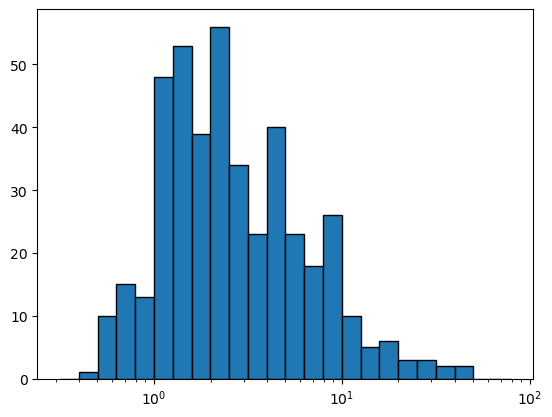

In [12]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [13]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [14]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [15]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [16]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [17]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [18]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [19]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [20]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
15,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11


In [21]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
5494,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [22]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [23]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [24]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [25]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [26]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,0.167060
1,Previous Market Price_2,-0.074821
2,Previous Market Price_3,0.029078
3,Previous Market Price_4,-0.034503
4,Previous Market Price_5,-0.122030
5,Market Price,1.002076
6,Foil_Holofoil,-0.190213
7,Foil_Normal,0.061893
8,Foil_Reverse Holofoil,0.128320


In [27]:
y_pred = classifier.predict(X_test)

In [28]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [29]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9978
r2:  0.9978
MAE:  0.3416
MSE:  3.3686
RMSE:  1.8354


# LSTM

In [30]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [31]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
5493    0.07
5494    0.08
5495    0.10
5496    0.11
5497    0.10
Name: Market Price, Length: 1720, dtype: float64

In [32]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(32, input_dim=1, return_sequences=False))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mean_squared_error'])  

In [ ]:
history = model.fit(X_train, y_train,epochs=1500)

In [34]:
y_pred = np.squeeze(model.predict(X_test))

32/32 [==============================] - 1s 1ms/step


In [35]:
((y_pred-y_test)**2).mean()

121.99549246418451

In [36]:
train_preds = np.squeeze(model.predict(X_train))

54/54 [==============================] - 0s 1ms/step


In [37]:
((train_preds-y_train)**2).mean()

0.11029155024267248